±# OSSEN Tutorial-Elsa Arcaute: Street Network and Accessibility

Authors:
- Elsa Arcaute (e.arcaute@ucl.ac.uk)
- Miao Zeng (ucbqmz7@ucl.ac.uk)
- Andrew Renninger (andrew.renninger.12@ucl.ac.uk)
- Xiuning Zhang (xiuning.zhang.23@ucl.ac.uk)

## Introduction
This tutorial is designed to introduce you to the analysis of urban networks using Python. The tutorial is divided into  parts:
1. **Street Network**: this part show you how to represent and analysis the street system as a network using the OSMnx library. It help you to download and analyze spatial data from OpenStreetMap. Besides the basic statistic description of the street networks, we will then apply percolation analysis to the street network to find spatial clusters on different scales.
2. **Accessibility Modelling**: Using the R5Py library to calculate the travel time matrix and analyze the accessibility of urban amenities in Oxford.

In [2]:
# Install all required packages for the tutorial
# !pip install -q --upgrade pip
!pip install -q matplotlib networkx osmnx r5py mapclassify colorcet geopandas folium

## Part I Street Network
The 1st part of this tutorial, we will learn one specific kind of urban networks —— the street networks:
1. Understand how to represent the street system as network.
2. Learn to use the OSMnx library.

### 1.Represent Street Network as Graph
![street network representation](street_networks.png)

from: [Street Network Studies: from Networks to Models and their Representations](https://link.springer.com/article/10.1007/s11067-018-9427-9)

###  2 the OSMnx library
It is a python library to help you download and analyze spatial data from OpenStreetMap.
https://osmnx.readthedocs.io/en/stable/

OSMnx is built on top of GeoPandas, and Networkx:
* Downloads and creates a networkx graph ofstreet networks or other infrastructure networks
    * Automatically cleans(topologically corrects) the network for you.
* Download any other spatial geometries (buildings, POI's, place **boundaries**)

#### **Step 1** Install & Import Libraries

In [3]:
import networkx as nx
import osmnx as ox
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
# from osgeo import gdal

In [4]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning, module="pandas.core.frame")

# Set pandas display options for better readability
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

#### **Step 2** Acquire Street Network

In [5]:
# We can build a graph by giving the name of the place
G1 = ox.graph_from_place('Oxford, England, United Kingdom', network_type='drive')
print(type(G1))

<class 'networkx.classes.multidigraph.MultiDiGraph'>


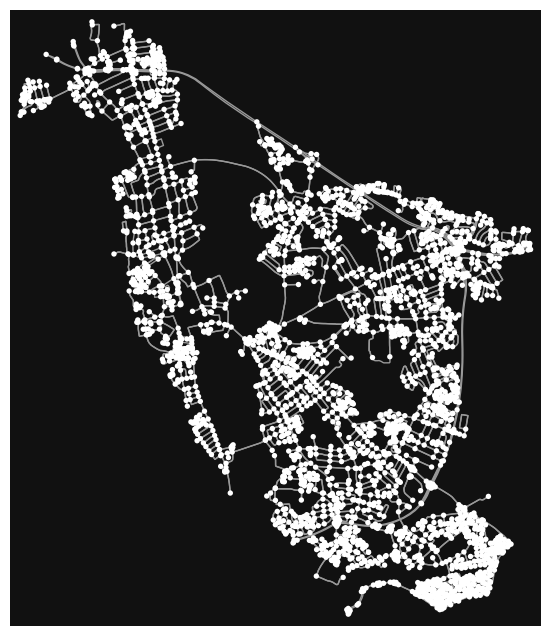

In [6]:
fig, ax = ox.plot_graph(G1)


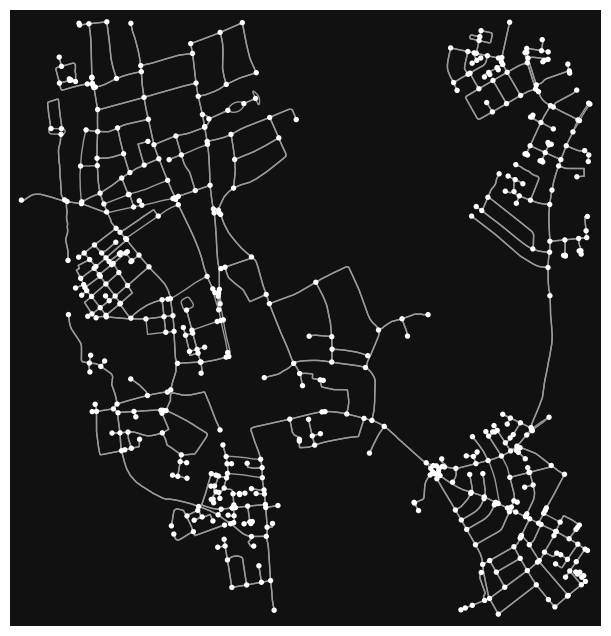

In [7]:
# We can also build a graph by giving the coordinates and a radius

Uni_Oxford = (51.7570,-1.2545)
radius = 1500 #meters
G = ox.graph_from_point(Uni_Oxford, dist=radius, network_type='drive')
fig, ax = ox.plot_graph(G)

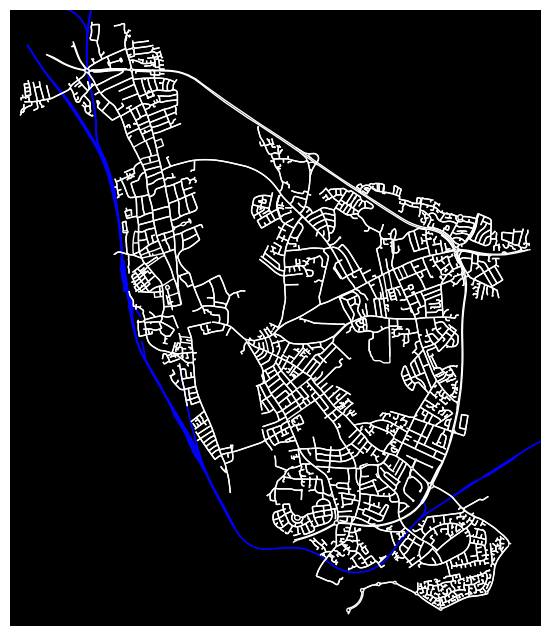

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [8]:
# We can also get other infrastructure networks
# change the overpass query to meet the new style 'New York, NY, USA'
G = ox.graph_from_place('Oxford, England, United Kingdom',
                        retain_all=False, truncate_by_edge=True, simplify=True,
                        custom_filter='["railway"]')

# Plot the railway network
fig, ax = ox.plot_graph(G, node_size=0, edge_color='blue', edge_linewidth=1, bgcolor='black', show=False, close=False)

# Plot the road network on top of the same figure
ox.plot_graph(G1, node_size=0, edge_color='w', edge_linewidth=1, bgcolor='black', ax=ax, show=True)

#### **Step 3** Understanding the Data Structure & Get some Basic Stats

In [9]:
# we can calculate basic street network metrics and display average circuity
stats = ox.basic_stats(G1)
stats

{'n': 3422,
 'm': 7590,
 'k_avg': 4.436002337814144,
 'edge_length_total': 667039.5381850647,
 'edge_length_avg': 87.88399712583197,
 'streets_per_node_avg': 2.3839859731151374,
 'streets_per_node_counts': {0: 0, 1: 1112, 2: 31, 3: 2132, 4: 147},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.3249561659848042,
  2: 0.009059029807130333,
  3: 0.6230274693161894,
  4: 0.042957334891876094},
 'intersection_count': 2310,
 'street_length_total': 361338.4278467757,
 'street_segment_count': 4065,
 'street_length_avg': 88.89014215172834,
 'circuity_avg': 1.0605519796792169,
 'self_loop_proportion': 0.004920049200492005}

In [10]:
# calculate betweenness with a digraph of G (ie, no parallel edges)
bc = nx.betweenness_centrality(ox.convert.to_digraph(G1), weight="length")

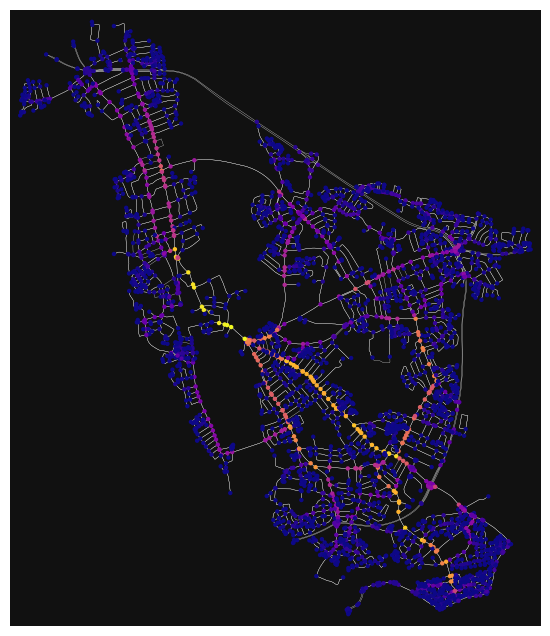

In [11]:
# add the betweenness centraliy values as new node attributes, then plot
nx.set_node_attributes(G1, bc, "bc")
nc = ox.plot.get_node_colors_by_attr(G1, "bc", cmap="plasma")
fig, ax = ox.plot_graph(
    G1,
    node_color=nc,
    node_size=10,
    node_zorder=2,
    edge_linewidth=0.2,
    edge_color="w",
)

#### **Step 4** Acquire Other Spatial Data

In [12]:
# get building footprints for the University of Oxford
buildings = ox.features_from_point(Uni_Oxford, dist=radius,tags={'building':True})
# get amenities for the University of Oxford
amenities = ox.features_from_point(Uni_Oxford,dist=radius,tags={'amenity':True, 'geometry':'point'})


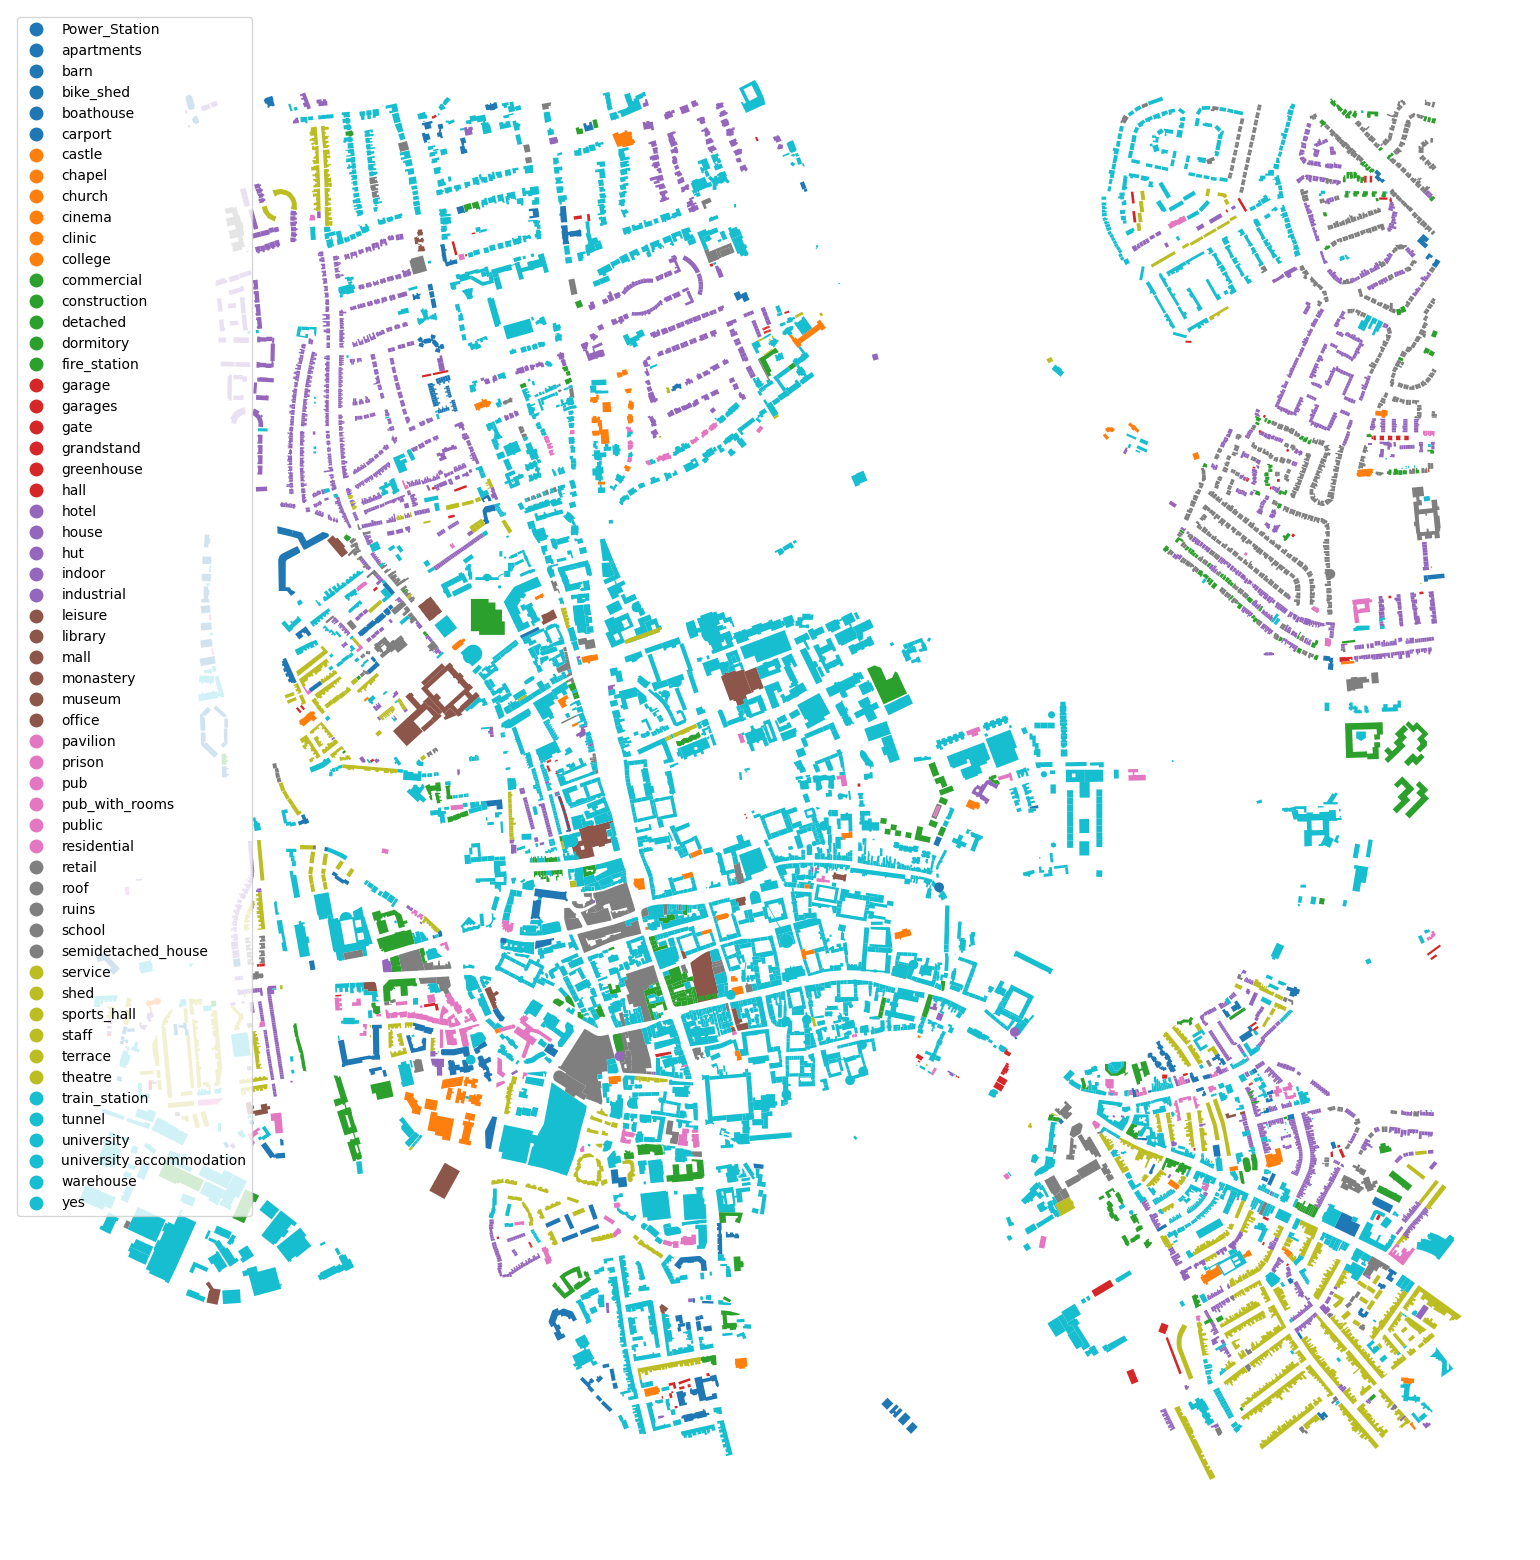

In [13]:
ax = buildings.plot(column='building', figsize=(20, 20), legend=True)
ax.set_axis_off()

**Exercise**

Now that we have shown you how to build a query to Open Street Map using `custom_filter`, see if you can do one yourself for the city of your choosing.

1. Look at this [table](https://wiki.openstreetmap.org/wiki/Map_features) that shows the names of OSM features
2. Substitute some of those into the query above
4. Make sure do one query that gets amenities, like restaurants or cafes and do another for a class of road

Hit: points of interest, like amenities, come from `geometries_from_*` rather than `graph_from_*`. Use the "tags" field to choose what kinds of features you want to download in this function.

---

Something the may be important to your work will be distinguishing "motorway", "primary", "secondary", "tertiary" roads as well as downloading "footpath". Another thing that OSMnx can do is download amenities, which is important to spatial interaction modelling: amenities can take the place of population at destination when we try to model the attractiveness.

## Part II Percolation and accessibility
In this section, we will conduct some analysis using obtained spatial network data.

### 3 Percolation analysis
This section will apply percolation clustering analysis to the street network.

Percolation can be used to identify the clusters of areas that are connected within a certain distance threshold. The process consists of a series of thresholdings of the network, in which weak links get disconnected. For each threshold, different subgraphs emerged as the network starts to disconnect. The percolation threshold is the point at which the network transitions from a collection of isolated clusters to a single connected cluster.

#### **Step 1** Transform to A Undirected Graph

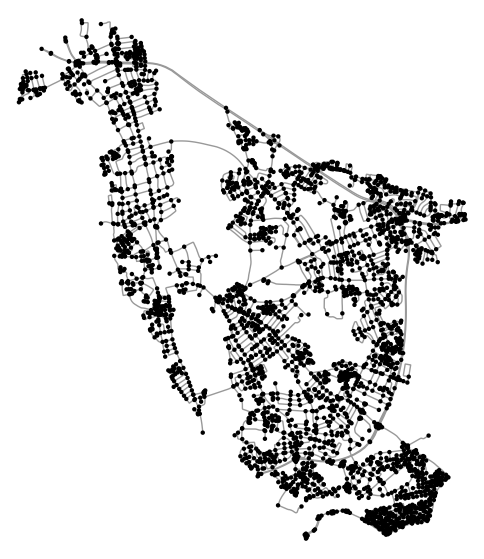

In [14]:
# convert your MultiDiGraph to an undirected MultiGraph
G2 = ox.convert.to_undirected(G1)

fig, ax = plt.subplots(figsize=(12,7))
fig, ax = ox.plot_graph(G2,
                        node_color='k',
                        node_size = 10,
                        ax=ax)

In [15]:
ox.basic_stats(G1)

{'n': 3422,
 'm': 7590,
 'k_avg': 4.436002337814144,
 'edge_length_total': 667039.5381850647,
 'edge_length_avg': 87.88399712583197,
 'streets_per_node_avg': 2.3839859731151374,
 'streets_per_node_counts': {0: 0, 1: 1112, 2: 31, 3: 2132, 4: 147},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.3249561659848042,
  2: 0.009059029807130333,
  3: 0.6230274693161894,
  4: 0.042957334891876094},
 'intersection_count': 2310,
 'street_length_total': 361338.4278467757,
 'street_segment_count': 4065,
 'street_length_avg': 88.89014215172834,
 'circuity_avg': 1.0605519796792169,
 'self_loop_proportion': 0.004920049200492005}

In [16]:
ox.basic_stats(G2)

{'n': 3422,
 'm': 4065,
 'k_avg': 2.375803623611923,
 'edge_length_total': 361338.4278467757,
 'edge_length_avg': 88.89014215172834,
 'streets_per_node_avg': 2.3839859731151374,
 'streets_per_node_counts': {0: 0, 1: 1112, 2: 31, 3: 2132, 4: 147},
 'streets_per_node_proportions': {0: 0.0,
  1: 0.3249561659848042,
  2: 0.009059029807130333,
  3: 0.6230274693161894,
  4: 0.042957334891876094},
 'intersection_count': 2310,
 'street_length_total': 361338.4278467757,
 'street_segment_count': 4065,
 'street_length_avg': 88.89014215172834,
 'circuity_avg': 1.0605519796792169,
 'self_loop_proportion': 0.004920049200492005}

#### **Step 2** Check Edges & Nodes

In [17]:
# From Graph to GeoDataFrame
nodes, edges = ox.graph_to_gdfs(G2)
nodes

y         x  street_count        bc highway  \
osmid                                                              
213309       51.762899 -1.180401             3  0.000292     NaN   
213313       51.762403 -1.191741             3  0.006217     NaN   
213315       51.762825 -1.195089             3  0.005171     NaN   
213318       51.763100 -1.196393             3  0.066158     NaN   
213319       51.762770 -1.196465             3  0.058669     NaN   
...                ...       ...           ...       ...     ...   
11868535406  51.751680 -1.237404             3  0.125532     NaN   
11871616420  51.764161 -1.196009             1  0.000000     NaN   
11935823423  51.769350 -1.208596             3  0.001162     NaN   
11935835319  51.763794 -1.204672             1  0.000000     NaN   
12003627514  51.760092 -1.198712             1  0.000000     NaN   

                              geometry  
osmid                                   
213309         POINT (-1.1804 51.7629)  
213313        POINT (-1.19174 51.7624)  
213315       POINT (-1.19509 51.76282)  
213318        POINT (-1.19639 51.7631)  
213319       POINT (-1.19647 51.76277)  
...                                ...  
11868535406   POINT (-1.2374 51.75168)  
11871616420  POINT (-1.19601 51.76416)  
11935823423   POINT (-1.2086 51.76935)  
11935835319  POINT (-1.20467 51.76379)  
12003627514  POINT (-1.19871 51.76009)  

[3422 rows x 6 columns]

In [18]:
edges

osmid       highway   lanes  \
u           v           key                                                   
213309      8399368007  0                   148359466         trunk       2   
            10069541058 0                   904416096    trunk_link     NaN   
            8399367992  0                   148359466         trunk       2   
213313      185420032   0                    37728512   residential     NaN   
            213315      0      [37728513, 1136744506]         trunk  [3, 4]   
...                                               ...           ...     ...   
11751666882 11751666888 0                   148463360         trunk       2   
                        1    [1264990435, 1264990436]  unclassified       1   
11862527048 11935823423 0    [1277858121, 1277858124]   residential     NaN   
11863259795 11935823423 0    [1277858121, 1277937783]   residential     NaN   
11868535405 11868535406 0                  1278435463       primary       2   

                            maxspeed             name  oneway   ref reversed  \
u           v           key                                                    
213309      8399368007  0     50 mph      London Road    True   A40    False   
            10069541058 0     50 mph              NaN    True   NaN    False   
            8399367992  0     50 mph      London Road    True   A40    False   
213313      185420032   0     20 mph  Collinwood Road   False   NaN    False   
            213315      0     30 mph      London Road    True   A40    False   
...                              ...              ...     ...   ...      ...   
11751666882 11751666888 0     70 mph   Woodstock Road    True   A44    False   
                        1        NaN              NaN    True   NaN    False   
11862527048 11935823423 0     20 mph   Boyce Crescent   False   NaN     True   
11863259795 11935823423 0     20 mph   Boyce Crescent   False   NaN    False   
11868535405 11868535406 0     20 mph     London Place    True  A420    False   

                                 length  \
u           v           key               
213309      8399368007  0     99.218652   
            10069541058 0    112.399238   
            8399367992  0     37.597423   
213313      185420032   0     21.859874   
            213315      0    235.687975   
...                                 ...   
11751666882 11751666888 0     26.167391   
                        1     89.179217   
11862527048 11935823423 0    100.034766   
11863259795 11935823423 0      8.910065   
11868535405 11868535406 0     36.458693   

                                                                      geometry  \
u           v           key                                                      
213309      8399368007  0    LINESTRING (-1.1804 51.7629, -1.18171 51.7627,...   
            10069541058 0    LINESTRING (-1.1804 51.7629, -1.18071 51.7629,...   
            8399367992  0      LINESTRING (-1.17987 51.76298, -1.1804 51.7629)   
213313      185420032   0     LINESTRING (-1.19178 51.76221, -1.19174 51.7624)   
            213315      0    LINESTRING (-1.19174 51.7624, -1.19309 51.7626...   
...                                                                        ...   
11751666882 11751666888 0    LINESTRING (-1.28354 51.79157, -1.28366 51.79179)   
                        1    LINESTRING (-1.28354 51.79157, -1.28369 51.791...   
11862527048 11935823423 0    LINESTRING (-1.2086 51.76935, -1.20866 51.7693...   
11863259795 11935823423 0    LINESTRING (-1.2086 51.76935, -1.20855 51.7693...   
11868535405 11868535406 0    LINESTRING (-1.23699 51.75188, -1.23711 51.751...   

                                    from           to junction access width  \
u           v           key                                                   
213309      8399368007  0         213309   8399368007      NaN    NaN   NaN   
            10069541058 0         213309  10069541058      NaN    NaN   NaN   
            8399367992  0     839936

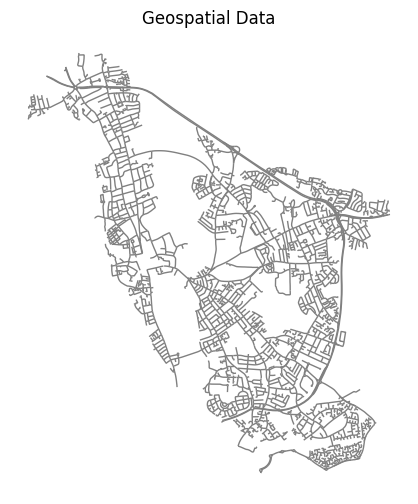

In [19]:
# Plot the GeoDataFrame
fig, ax = plt.subplots(1, 1, figsize=(10, 6))

# You can customize the plot with different options
edges.plot(ax=ax, color='grey', linewidth=1, edgecolor='black')

# Optionally, you can add titles and labels
ax.set_title('Geospatial Data')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_axis_off()

# Show the plot
plt.show()

In [20]:
#get a simplified node list
data_coords = nodes[["x","y"]]
data_coords['id_point'] = data_coords.index
data_coords

/var/folders/1m/ypxywhtn55lb617x58888rqh0000gn/T/ipykernel_5539/1102546560.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_coords['id_point'] = data_coords.index


x          y     id_point
osmid                                        
213309      -1.180401  51.762899       213309
213313      -1.191741  51.762403       213313
213315      -1.195089  51.762825       213315
213318      -1.196393  51.763100       213318
213319      -1.196465  51.762770       213319
...               ...        ...          ...
11868535406 -1.237404  51.751680  11868535406
11871616420 -1.196009  51.764161  11871616420
11935823423 -1.208596  51.769350  11935823423
11935835319 -1.204672  51.763794  11935835319
12003627514 -1.198712  51.760092  12003627514

[3422 rows x 3 columns]

#### **Step 3** Percolation
The process consists of a series of thresholds of the network. Through setting different distance thresholds, different subgraphs emerged as the network starts to disconnect.

Note that the thresholds are NOT universal. Also that the networks from the OMS are incomplete, hence more detail, referring to smaller streets being present, will only be given in cities where the effort to map those streets has been put into it. Hence, different distances will be found for the transitions in different cities.

First let us define the vector containing the percolation thresholds of interest

In [21]:
rmin = 10  #10 metres as the starting distance threshold
rmax = 1001 #1000 metres as the ending threshod
r0 = np.arange(rmin, rmax, 10)
n_loops = len(r0)

file_clust_size = 'cluster_size.txt'
with open(file_clust_size, 'w') as file:
    file.write('threshold\t size\n')

Define the thresholds to plot the 10 largest clusters on maps

In [22]:
jumps_2plot = [90,160,200,210,260,290,330]

In [23]:
# Define the colors for the top 10 clusters
top10 = ['red', 'green', 'blue', 'orange', 'purple', 'yellow', 'pink', 'cyan', 'magenta', 'brown']

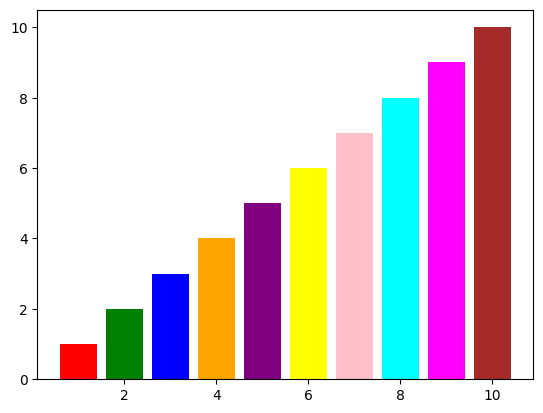

In [24]:
# Visualize the colors
plt.bar(range(1, 11), range(1, 11), color=top10)
plt.show()

In [25]:
# Obtain the node counts of the network
size_net = G2.number_of_nodes()
size_net


3422

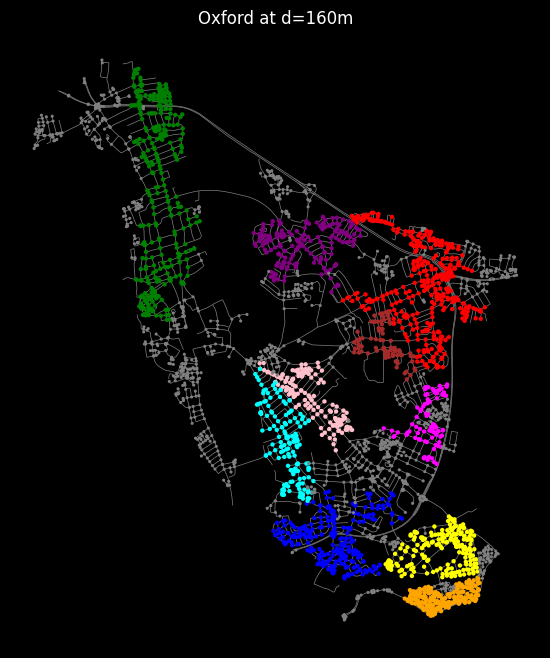

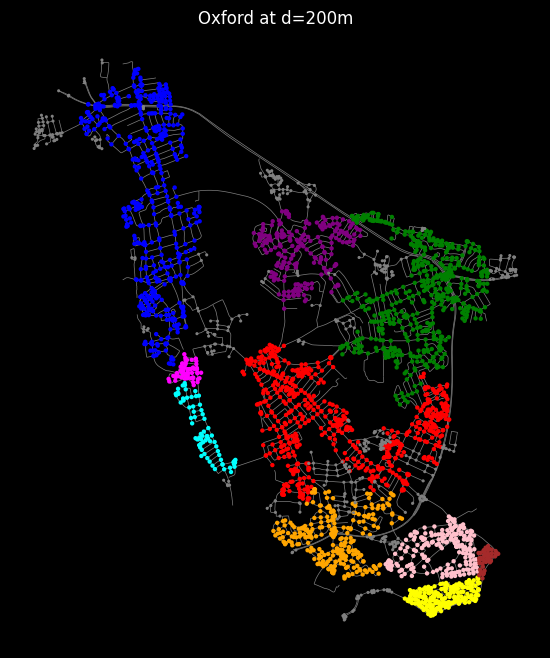

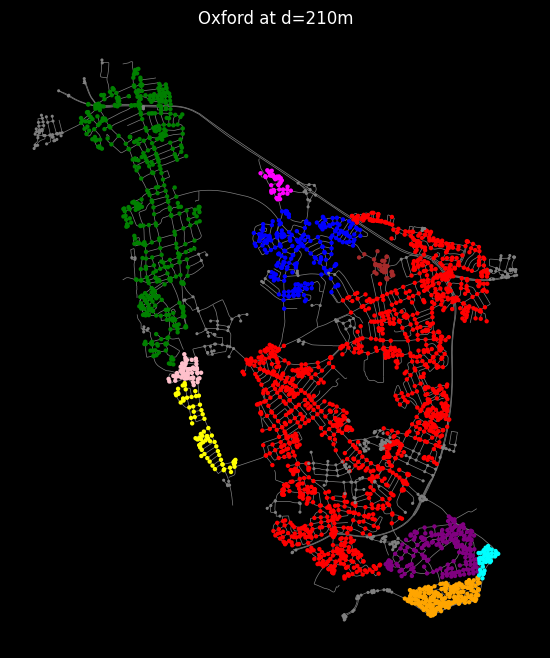

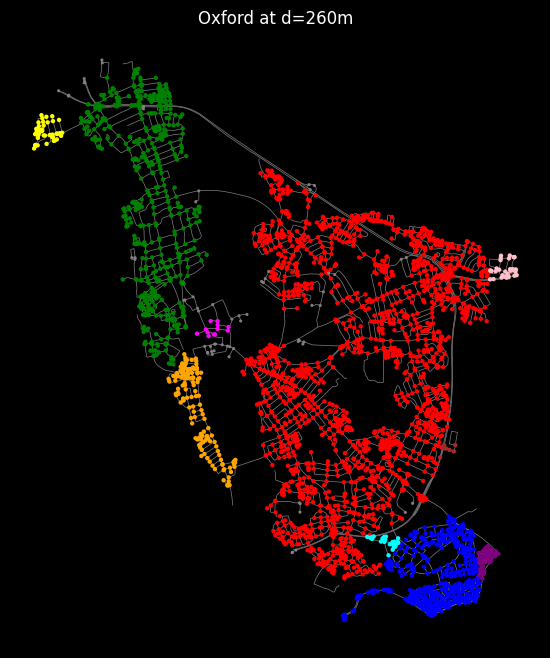

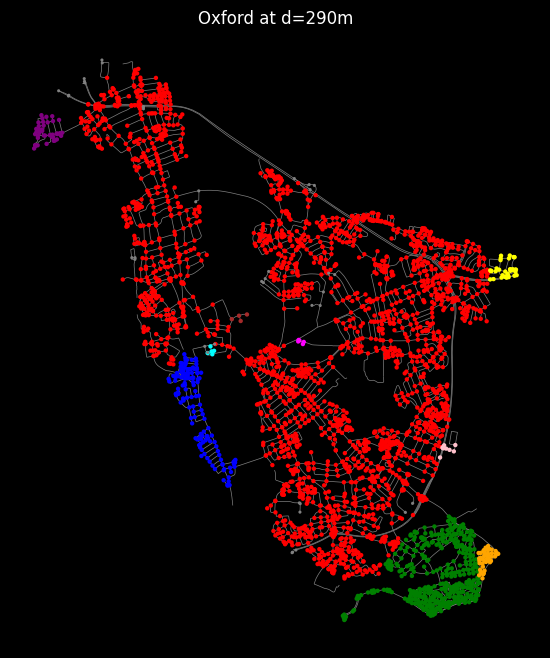

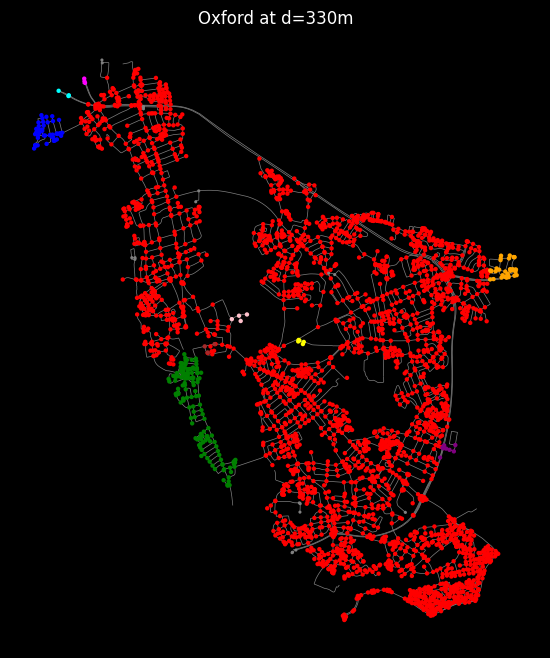

In [26]:
#Percolation process & plot
for i_t in r0:
    # Find subgraph such that all weights <= threshold r0
    edges_1 = [(u, v, d) for u, v, d in G2.edges(data=True) if d['length'] <= i_t]
    g = nx.Graph()
    g.add_edges_from(edges_1)
    g.remove_nodes_from(list(nx.isolates(g)))

    # Take subcomponents
    membclusters = {node: cid for cid, component in enumerate(nx.connected_components(g)) for node in component}

    m = pd.DataFrame(list(membclusters.items()), columns=["id_point", "id_cluster"])

    table_data = m['id_cluster'].value_counts()

    # Largest connected component
    LCC = table_data.max()
    LCC_p = LCC / size_net
    v_LCC = [i_t, LCC, LCC_p]

    if i_t == rmin:
        v_LCC_t = np.array([v_LCC])
    else:
        v_LCC_t = np.vstack([v_LCC_t, v_LCC])

    sorted_table = table_data.sort_values(ascending=False)

    if i_t in jumps_2plot:

        # Assign colours
        list_clusts = sorted_table.reset_index()
        list_clusts.columns = ["id_cluster", "n_points"]
        list_clusts['colour'] = 'grey'
        list_clusts.loc[:9, 'colour'] = top10
        list_clusts['size'] = 0.1
        list_clusts.loc[:9, 'size'] = 0.2

        total_list = pd.merge(list_clusts, m, on="id_cluster")

        points_coords_cols = pd.merge(total_list, data_coords, on="id_point")


        # # Plot the original street network system  as background
        # fig, ax = plt.subplots(1, 1, figsize=(10, 8),facecolor='black')
        # edges.plot(ax=ax, color='grey', edgecolor='black')

        # # plt.savefig(file_map, height=850, width=1000)
        # plt.figure(figsize=(10, 8), facecolor='black')
        # plt.scatter(points_coords_cols['x'], points_coords_cols['y'], s=points_coords_cols['size'] * 50, c=points_coords_cols['colour'], edgecolor='none')
        # plt.title(f"Oxford at d={i_t}m", color='white')
        # plt.axis('off')
        # plt.show()
        # # plt.savefig(file_map)
        # # plt.close()

        # Plot the original street network system as background
        fig, ax = plt.subplots(1, 1, figsize=(10, 8), facecolor='black')


        # Plot points
        ax.scatter(points_coords_cols['x'], points_coords_cols['y'], s=points_coords_cols['size'] * 50, c=points_coords_cols['colour'], edgecolor='none',zorder = 1)

         # Plot edges geometry as background
        edges.plot(ax=ax, color='grey', linewidth=0.5, zorder = 0)

        ax.set_title(f"Oxford at d={i_t}m", color='white')
        ax.axis('off')

        plt.show()


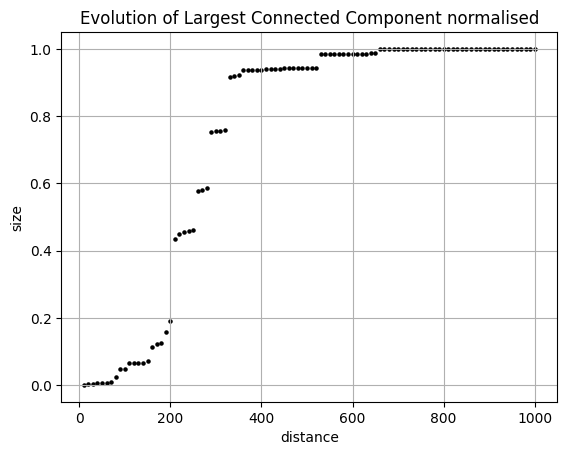

In [27]:
import matplotlib.pyplot as plt

plt.figure(facecolor='white')

plt.scatter(v_LCC_t[:, 0], v_LCC_t[:, 2], c='black', s=5)
plt.grid(True)

plt.xlabel("distance")
plt.ylabel("size")
plt.title("Evolution of Largest Connected Component normalised")

plt.show()


### 4 Retail Accessibility in Oxford

Today we are going to use the street network to compute measures of accessibility. To do this, we will lean on "Dijkstra's algorithm", which is a method for finding the shortest path between two points in a graph. In this case, the graph is the street network, and the points are intersections of streets.

**Dijkstra's Algorithm Steps:**

1. Initialize all nodes with infinite distance; set starting node distance to 0
2. Select the unvisited node with minimum distance
3. Mark the selected node as visited
4. Update distances to all adjacent unvisited nodes
5. Repeat steps 2-4 until destination is reached or all nodes are visited

[**N.B.** When you are working with very large graphs, you might try the A* algorithm, which is a more efficient version of Dijkstra's algorithm. It limits the search space by establishing a maximum "detour" beyond the direct path, focusing only on promising routes. So you can imagine, if you are trying to get from Berlin to Rome, your street network might be all of Europe but we could throw out the possibility of going through Athens or something.]

In [28]:
# Additional imports for this section
import colorcet as cc
import re

#### Step 1: Preparation
Let's start by getting the data, slightly different from the previous one because we want to see **walking** behaviour.

In [29]:
# Grab the street network for our area of interest, this time for walking
G_walk = ox.graph.graph_from_place('Oxford, England, United Kingdom', network_type='walk')

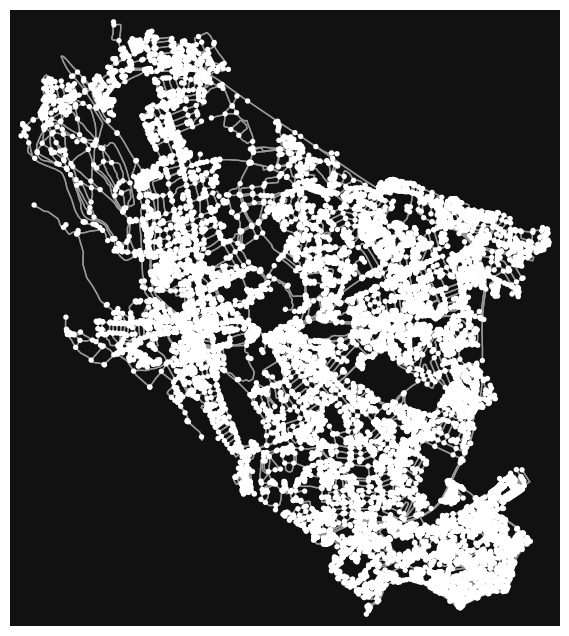

In [30]:
# Remember how to plot the graph
fig, ax = ox.plot_graph(G_walk)

In [31]:
# Get the administrative boundary of the area
area = ox.geocode_to_gdf('Oxford, England, United Kingdom')

In [32]:
area.explore()

For this section, we are going to use data on grocery stores from OpenStreetMap.

In [33]:
retail = pd.read_csv("geolytix_retailpoints_v34_202412.csv")
retail = gpd.GeoDataFrame(retail, geometry=gpd.points_from_xy(retail['long_wgs'], retail['lat_wgs']), crs="EPSG:4326")
retail = retail[retail['geometry'].within(area.loc[0, 'geometry'])]
retail.head()

id                retailer                 fascia  \
3806  1010012709                Waitrose               Waitrose   
3807  1010008939  The Co-operative Group  The Co-operative Food   
3808  1010017001                    Spar                   Spar   
3812  1010005419                   Tesco          Tesco Express   
3814  1010022000                    Cook                   Cook   

                           store_name                             add_one  \
3806      Waitrose Oxford Botley Road                         Botley Road   
3807             Co-op Cherwell Drive                   22 Cherwell Drive   
3808                Spar - Headington              10-12 Underhill Circus   
3812  Tesco Oxford St Aldates Express                      75 St Aldate's   
3814                      Cook Oxford  237 Banbury Road Summertown Oxford   

     add_two    town          suburb postcode  long_wgs    lat_wgs  \
3806     NaN  Oxford          Botley  OX2 0HH -1.280490  51.753060   
3807     NaN  Oxford         Manston  OX3 0LY -1.231638  51.767982   
3808     NaN  Oxford      Headington  OX3 9LU -1.195715  51.767426   
3812     NaN  Oxford  Central Oxford  OX1 1RA -1.256797  51.748665   
3814     NaN  Oxford    North Oxford  OX2 7HN -1.265136  51.777365   

              bng_e          bng_n      pqi   open_date  \
3806  449763.982172  206285.667426  Rooftop  20151015.0   
3807  453118.690789  207979.618569  Rooftop         NaN   
3808  455598.250254  207944.438083  Rooftop         NaN   
3812  451404.399689  205813.200175  Rooftop         NaN   
3814  450796.628871  208999.411366  Rooftop         NaN   

                                   size_band       county  \
3806  15,069 < 30,138 ft2 (1,400 < 2,800 m2)  Oxfordshire   
3807                     < 3,013 ft2 (280m2)  Oxfordshire   
3808                     < 3,013 ft2 (280m2)  Oxfordshire   
3812                     < 3,013 ft2 (280m2)  Oxfordshire   
3814                     < 3,013 ft2 (280m2)  Oxfordshire   

                       geometry  
3806  POINT (-1.28049 51.75306)  
3807  POINT (-1.23164 51.76798)  
3808  POINT (-1.19571 51.76743)  
3812   POINT (-1.2568 51.74867)  
3814  POINT (-1.26514 51.77737)

In [34]:
# How many retail locations are there?
retail.shape

(52, 18)

In [35]:
# # Get grocery stores from OpenStreetMap
# # We select a variety of food-related amenities and shops
# tags = {"shop": ["supermarket"]}
# retail = ox.features_from_place('Oxford, England, United Kingdom', tags)
#
# # We are interested in point locations
# retail = retail[retail.geom_type == 'Point']
#
# print(f"Found {len(retail)} grocery stores in Oxford.")
# retail.head()

In [36]:
# # How many grocery locations are there?
# retail.shape

In [37]:
# Convert graph to GeoDataFrames
nodes_walk, edges_walk = ox.graph_to_gdfs(G_walk)

Text(0.5, 1.0, 'Retail in Oxford')

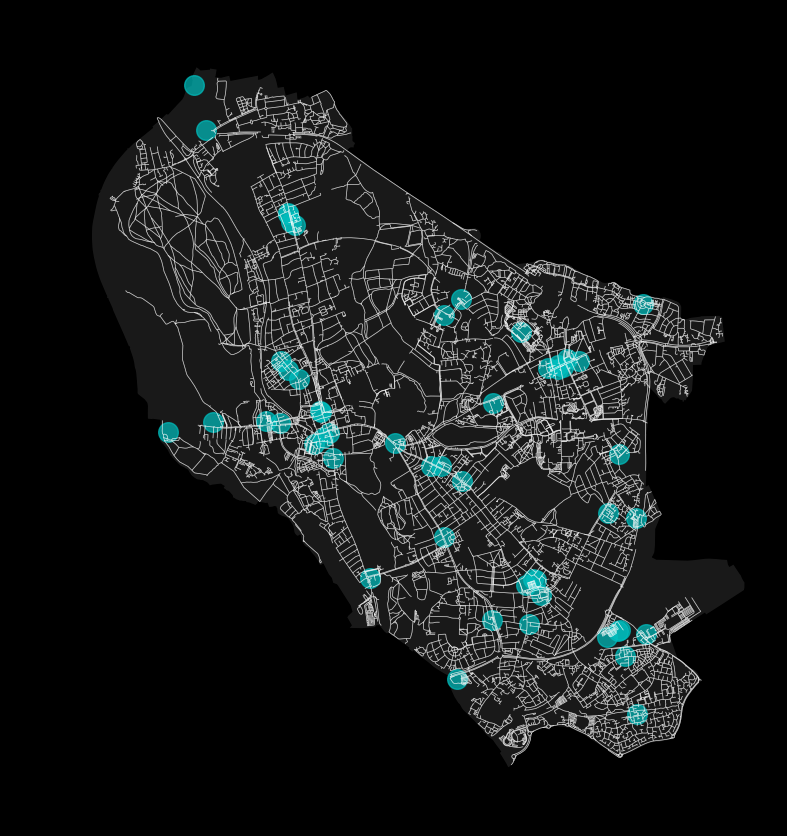

In [38]:
# Visualise the grocery stores on the map
fig, ax = plt.subplots(figsize=(10, 10), facecolor='k')
area.plot(ax=ax, facecolor='w', alpha=0.1)
edges_walk.plot(color='w', ax=ax, linewidth=0.5, alpha=0.5)
retail.plot(color='c', ax=ax, markersize=200, alpha=0.7)
ax.set_facecolor('k')
ax.set_title('Retail in Oxford')

#### Step 2: Catchment area and distance

In [39]:
# Get the nearest network node to each point
# Note: using geometry.x and .y is more robust for GeoDataFrames
retail['nodes'] = ox.nearest_nodes(G_walk, retail.geometry.x, retail.geometry.y)

In [40]:
retail['nodes'].to_numpy()

array([ 1327325839, 12648219776,   364838379, 10611593581,  1760463838,
        2268660024,  1332088185,  9381817252,  1754925277,   696696141,
       12807467393,    29063353,    16640069, 11507905365,  1383563057,
         355000537,   639133512,      213885,  1324797856,  2059871997,
       12912853047,  1327335133,  1324697093,  1281316811,  3178941726,
        1024074718,  1324797861, 10606112694,   279890181,  1718362871,
        9706884372,   401868577,  1491571445,  1445455800,     6524574,
       12139650329,  1324651559,    29063354,   529861992,  1760463842,
        1273290289,  7792057562, 11780564742,  1335956590,  3018165569,
         485607761,   485607761,  1947338610,  2313105548,  2934506667,
         238682880,  6991912907])

In [41]:
# Each node has an ID and coordinate
# G_walk.nodes(data=True) # This can be a very long output, let's not print it all
list(G_walk.nodes(data=True))[:5]

[(213309, {'y': 51.7627797, 'x': -1.1812265, 'street_count': 4}),
 (213313, {'y': 51.762403, 'x': -1.191741, 'street_count': 3}),
 (213315, {'y': 51.7628248, 'x': -1.195089, 'street_count': 3}),
 (213319, {'y': 51.7627696, 'x': -1.1964652, 'street_count': 3}),
 (213320, {'y': 51.7627214, 'x': -1.1970113, 'street_count': 3})]

A Voronoi diagram assigns points to a set of seed or generator points according to proximity.

In [42]:
# Get the shortest paths from all the nodes to all the entrance nodes
# This can take a moment
%time lines = nx.multi_source_dijkstra_path(G_walk, set(retail['nodes'].to_numpy()), weight='length')
# Voronoi cells creates a voronoi using the network rather than euclidean distance
%time cells = nx.voronoi_cells(G_walk, set(retail['nodes'].to_numpy()), weight='length')

CPU times: user 133 ms, sys: 3.61 ms, total: 136 ms
Wall time: 135 ms
CPU times: user 53.4 ms, sys: 2.41 ms, total: 55.9 ms
Wall time: 59.3 ms


For more actions on the Dijsktra algorithm, see `nx.dijkstra_*` and its many endings.

In [43]:
cells_df_list = [pd.DataFrame({'parent': x[0], 'child': list(x[1])}) for x in cells.items()]
merged = pd.concat(cells_df_list).merge(nodes_walk, left_on='child', right_on='osmid', how='left')

In [44]:
merged.head()

parent       child          y         x  street_count highway  ref  \
0  12648219776  8894900236  51.771524 -1.222227             3     NaN  NaN   
1  12648219776  1493403698  51.777067 -1.236267             1     NaN  NaN   
2  12648219776  1288235089  51.777097 -1.237178             3     NaN  NaN   
3  12648219776  1288235096  51.777173 -1.237812             1     NaN  NaN   
4  12648219776  1415903324  51.769630 -1.223334             3     NaN  NaN   

                    geometry  
0  POINT (-1.22223 51.77152)  
1  POINT (-1.23627 51.77707)  
2   POINT (-1.23718 51.7771)  
3  POINT (-1.23781 51.77717)  
4  POINT (-1.22333 51.76963)

Text(0.5, 1.0, 'Grocery Catchments')

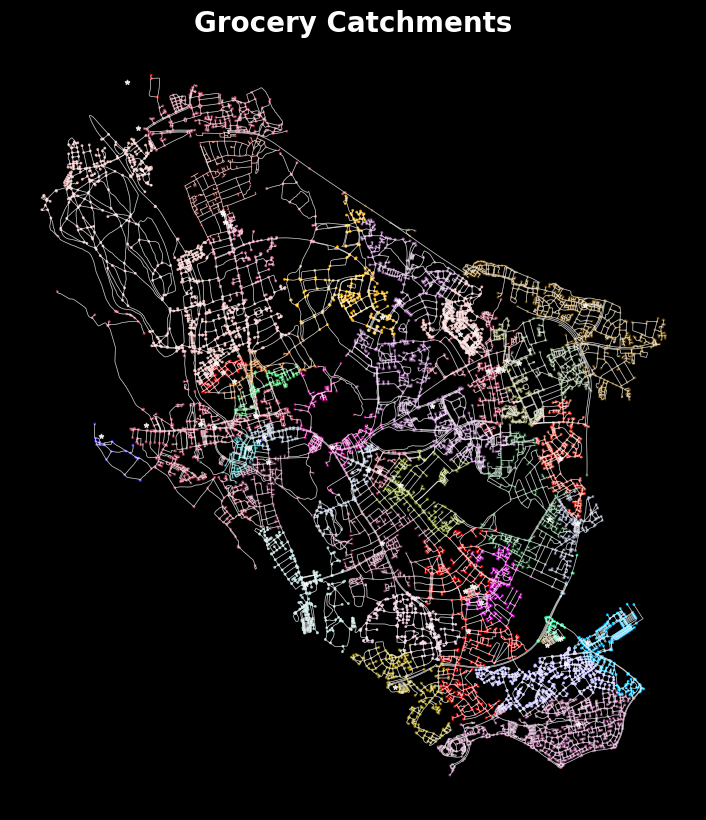

In [45]:
# Plot the edges in black
fig, ax = plt.subplots(figsize=(10, 10), facecolor='k')
edges_walk.plot(color='w', ax=ax, linewidth=0.5, alpha=0.5)

# Convert the merged cell dataframe to a geodataframe and plot it
gpd.GeoDataFrame(merged, 
                 geometry=gpd.points_from_xy(merged['x'], merged['y']), 
                 crs=4326).plot('parent', markersize=1, cmap=cc.cm.glasbey_dark, ax=ax)

# Plot the grocery stores in light grey to highlight them
retail.plot(color='w', ax=ax, markersize=10, alpha=0.8, marker='*')

# Clean it up
ax.set_axis_off()
ax.set_facecolor('k')

# Add a title
ax.set_title('Grocery Catchments', fontsize=20, fontweight='bold', color='w')

We have now assigned each intersection to its nearest grocery store.

In [46]:
# Let's check the distances to shops from all nodes
%time lengths = nx.multi_source_dijkstra_path_length(G_walk, set(retail['nodes'].to_numpy()), weight="length")

CPU times: user 46.1 ms, sys: 3.23 ms, total: 49.3 ms
Wall time: 52.7 ms


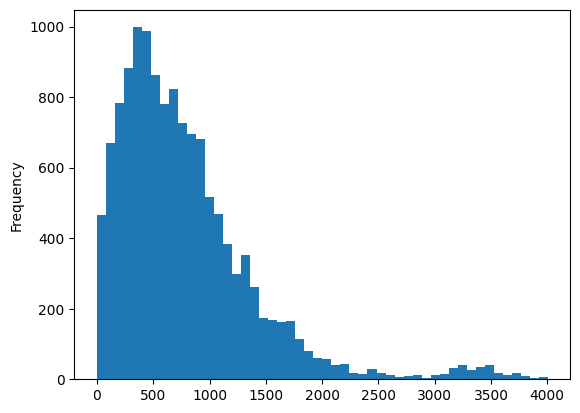

In [47]:
# Make a data frame of the lengths
lengths = pd.DataFrame({'osmid':lengths.keys(), 'distance': lengths.values()})
# There may be some outliers, let's remove nodes that are very far
# We can inspect the distribution to make a better choice
lengths['distance'].plot.hist(bins=50)
plt.show()

In [48]:
# Let's set a reasonable threshold, e.g., 5km for walking
lengths = lengths[lengths['distance'] < 5000]

In [49]:
# What is the average length?
int(lengths['distance'].mean())

785

In [50]:
# Let us check what is the max distance
int(lengths['distance'].max())

4004

Text(0.5, 1.0, 'Retail Distances')

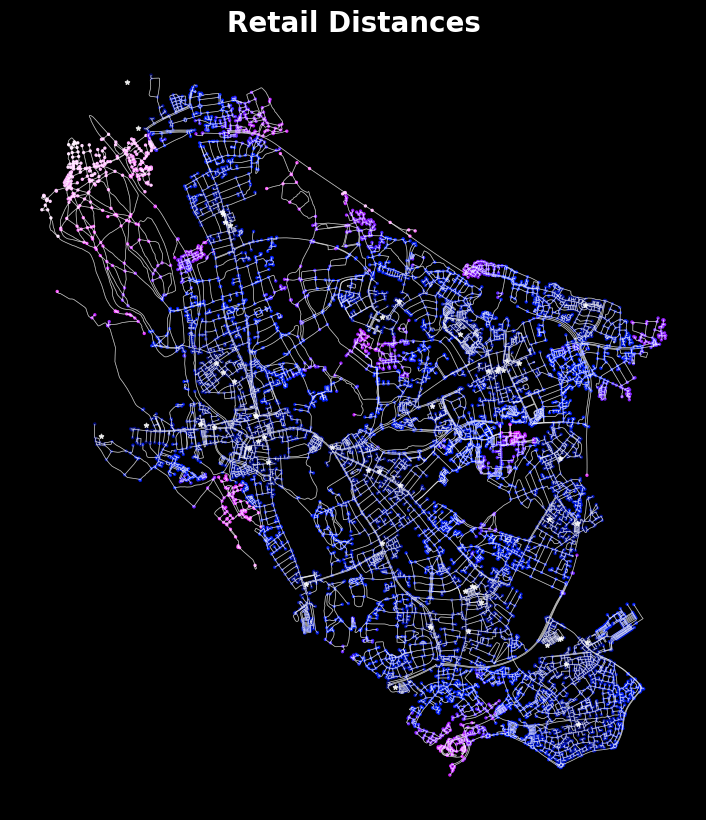

In [51]:
# Same as before but with distance as the column of interest
fig, ax = plt.subplots(figsize=(10, 10), facecolor='k')
edges_walk.plot(color='w', ax=ax, linewidth=0.5, alpha=0.5)
gpd.GeoDataFrame(merged, 
                 geometry=gpd.points_from_xy(merged['x'], merged['y']), 
                 crs=4326).merge(lengths, 
                                 left_on='child', 
                                 right_on='osmid',
                                 how='left').plot('distance', markersize=2, cmap=cc.cm.bmw, ax=ax)

# Plot the grocery stores in light grey to highlight them
retail.plot(color='w', ax=ax, markersize=10, alpha=0.8, marker='*')

# Clean it up
ax.set_axis_off()
ax.set_facecolor('k')

# Add a title
ax.set_title('Retail Distances', fontsize=20, fontweight='bold', color='w')

**Important:** For a practical, you will need to be able to create a matrix that contains the distance between all origins and all destinations. What we have done so far assigns each node to its nearest grocery store. You will need to create a matrix that contains the distance between all nodes. This is a bit more complex, but we will guide you through it.

[If you are using a square matrix, which we are not, you can use `nx.all_pairs_dijkstra_path_length`, but this takes a lot of computational power and time.]

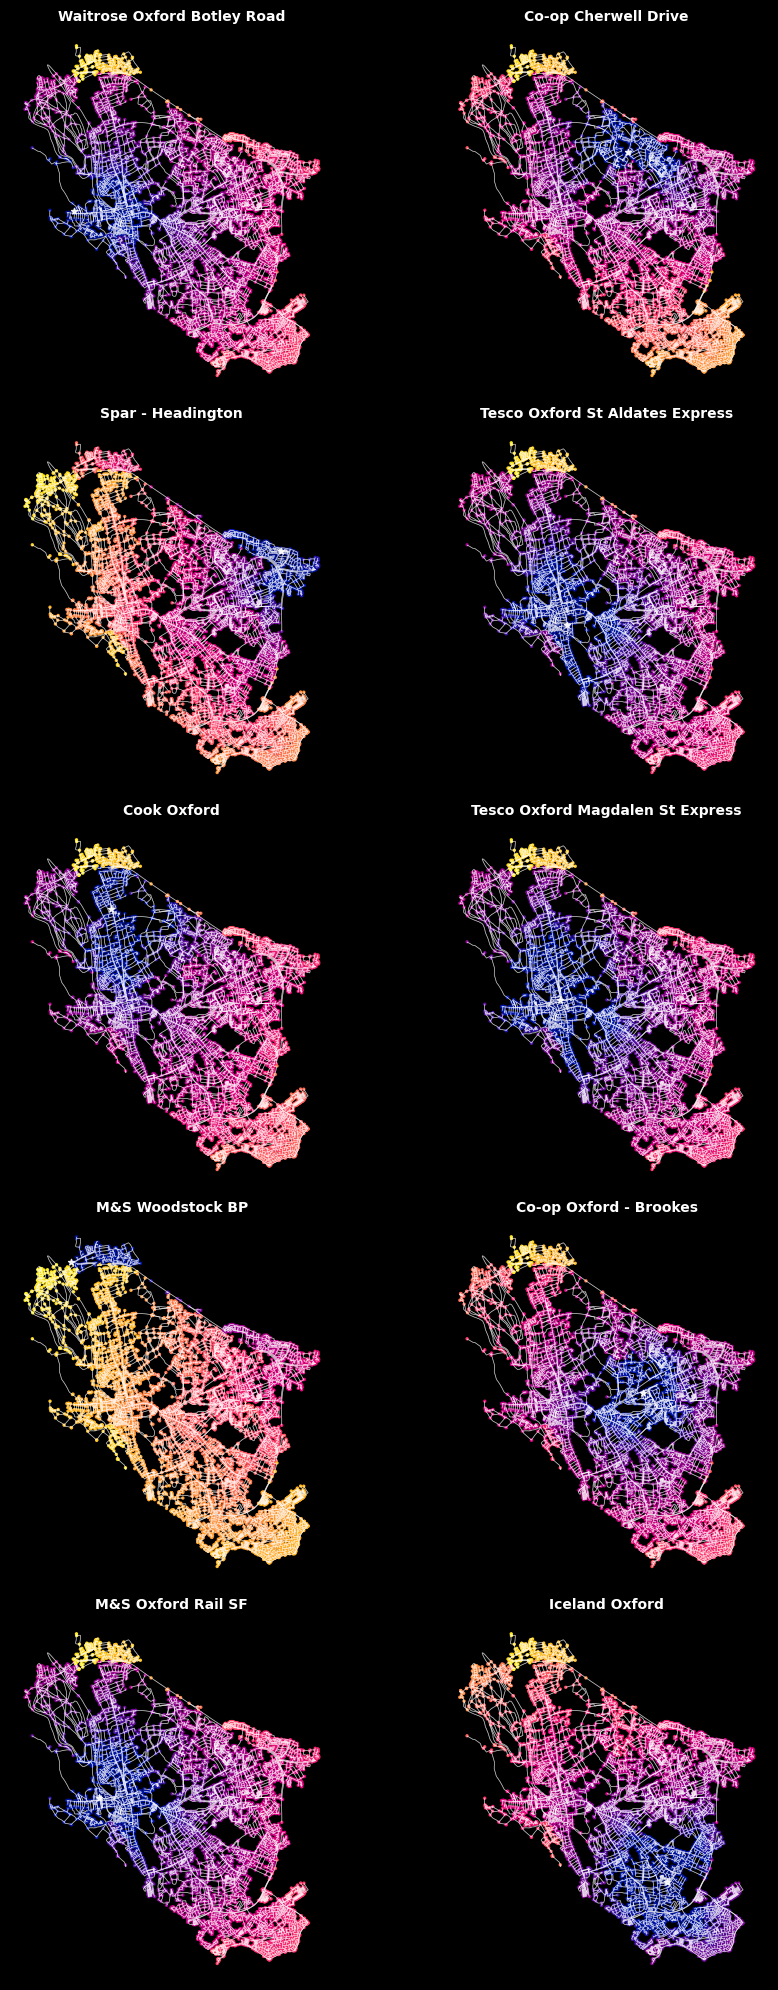

CPU times: user 30.8 s, sys: 533 ms, total: 31.3 s
Wall time: 31.4 s


In [52]:
%%time
distances = {}

# We are only going to plot the top 10 for visualisation purposes
# Let's make sure the 'name' column has no NaNs for titles
retail_named = retail.dropna(subset=['store_name']).reset_index(drop=True)
subset = retail_named.head(10)

fig, axs = plt.subplots(5, 2, figsize=(10, 20), facecolor='k')
axs = axs.ravel() 

# For each grocery store, let's get the distance to all nodes, and plot them all
for i, row in subset.iterrows():
    n = row['nodes']
    d = nx.single_source_dijkstra_path_length(G_walk, n, weight='length')
    d = pd.DataFrame({'osmid': d.keys(), 'distance': d.values()})
    distances[n] = d

    # Visualisation of first 10 grocery stores only
    if i < 25:
        
        edges_walk.plot(color='w', ax=axs[i], linewidth=0.5, alpha=0.5)
        gpd.GeoDataFrame(merged, 
                        geometry=gpd.points_from_xy(merged['x'], merged['y']), 
                        crs=4326).merge(d, 
                                        left_on='child', 
                                        right_on='osmid',
                                        how='left').plot('distance', markersize=2, cmap=cc.cm.bmy, ax=axs[i])
        
        retail[retail['nodes']==n].plot(color='w', ax=axs[i], markersize=20, alpha=0.9, marker='*')
        axs[i].set_axis_off()
        axs[i].set_facecolor('k')
        axs[i].set_title(row['store_name'], fontsize=10, fontweight='bold', color='w')

plt.tight_layout()
plt.show()

#### Step 3 Navigation & Routing

2361900476
3018165569


/var/folders/1m/ypxywhtn55lb617x58888rqh0000gn/T/ipykernel_5539/4172322596.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  Origin_point = buildings[buildings['name']=='Deneke'].geometry.centroid
/var/folders/1m/ypxywhtn55lb617x58888rqh0000gn/T/ipykernel_5539/4172322596.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  destination_point = retail.sample(1, random_state=33).geometry.centroid
/var/folders/1m/ypxywhtn55lb617x58888rqh0000gn/T/ipykernel_5539/4172322596.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  Origi

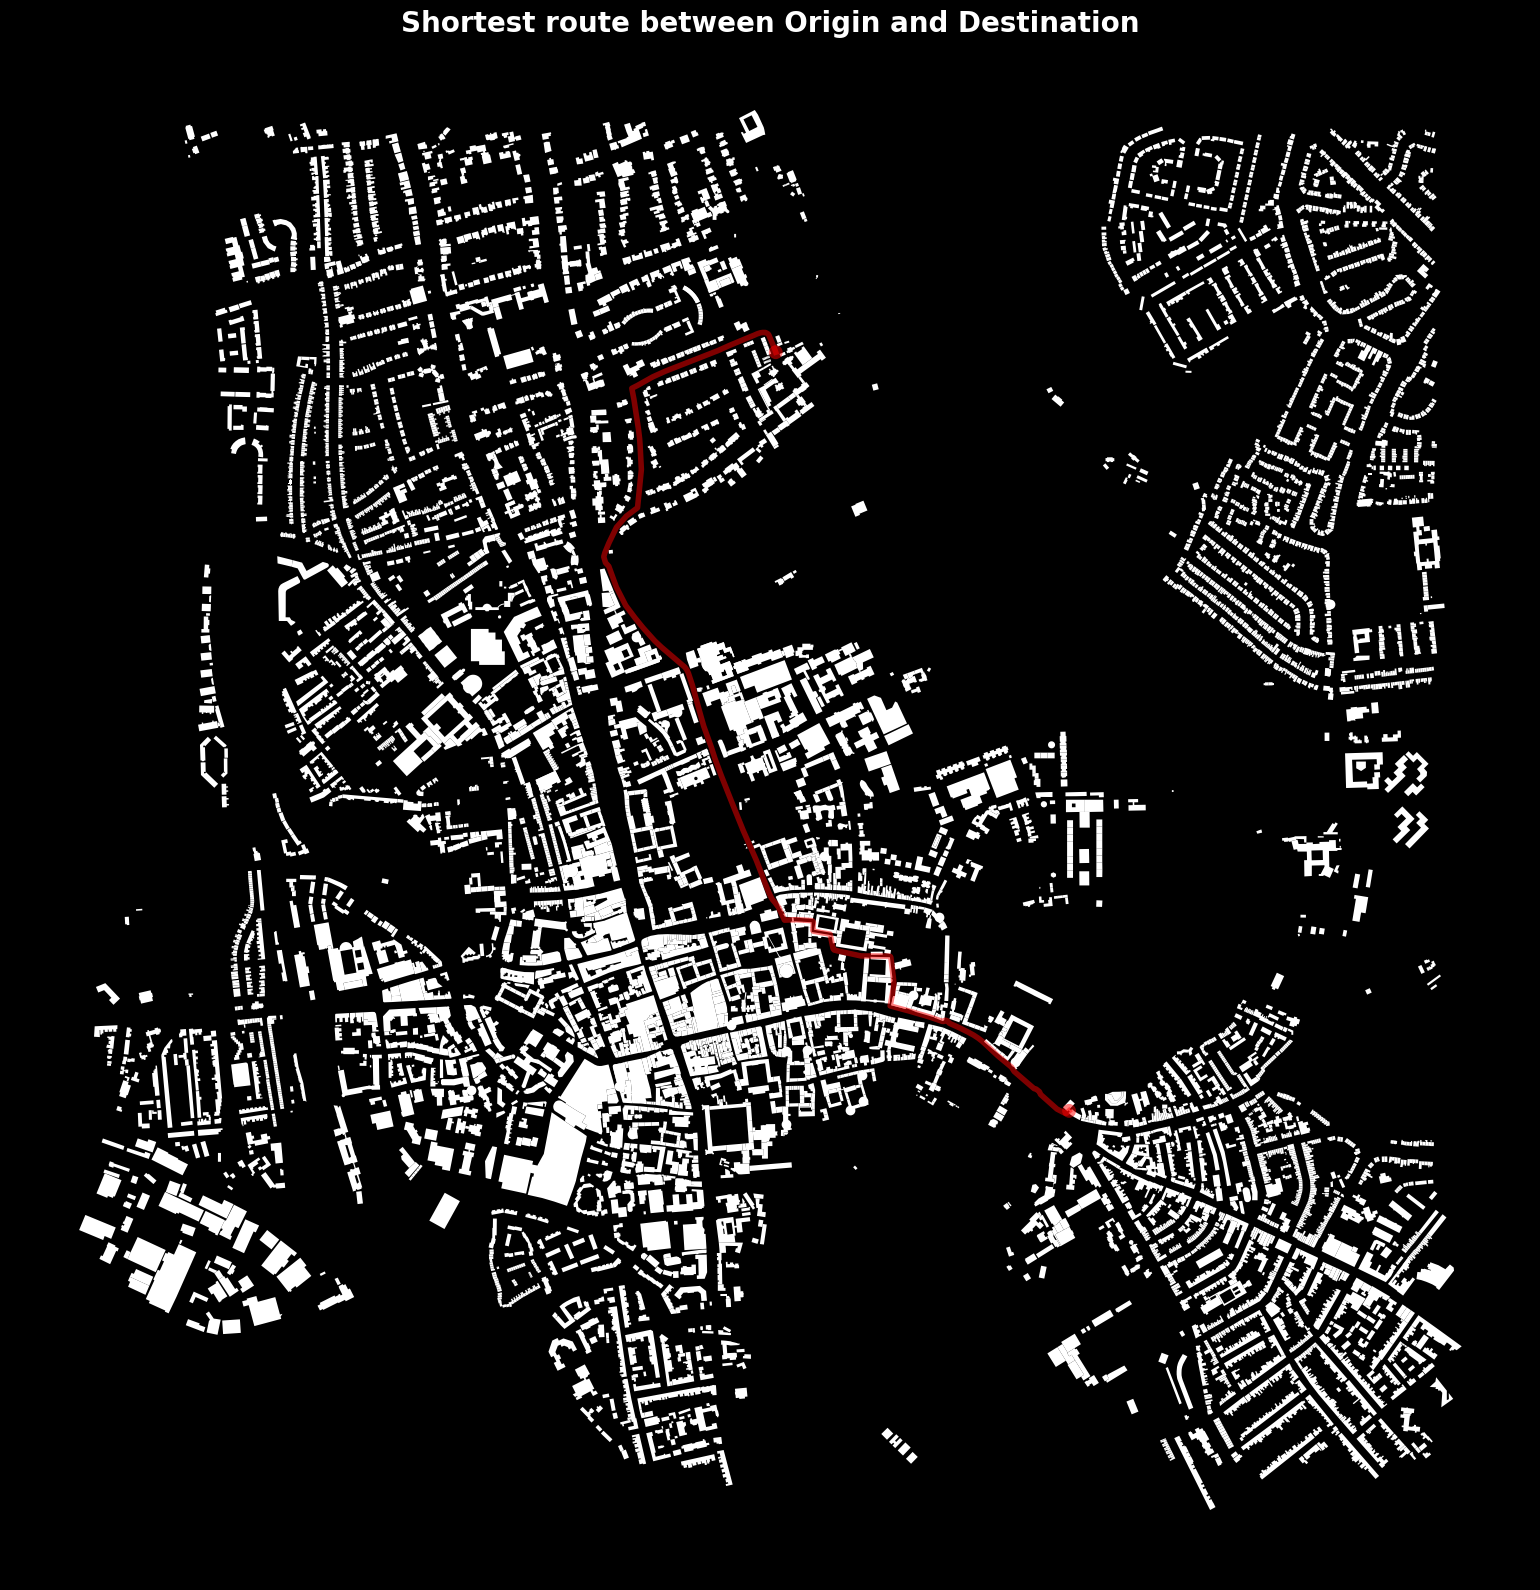

(<Figure size 2000x2000 with 1 Axes>,
 <Axes: title={'center': 'Shortest route between Origin and Destination'}>)

In [53]:
Origin_point = buildings[buildings['name']=='Deneke'].geometry.centroid
destination_point = retail.sample(1, random_state=33).geometry.centroid


Origin = ox.nearest_nodes(G_walk, Origin_point.x[0], Origin_point.y[0])
print(Origin)

destination = ox.nearest_nodes(G_walk, destination_point.x, destination_point.y)[0]
print(destination)

# get the shortest path between the two nodes
route = nx.shortest_path(G_walk, Origin, destination, weight='length')

# plot the route
fig, ax = plt.subplots(1, 1, figsize=(20, 20), facecolor='k', subplot_kw=dict(aspect='equal'))

# clean it up
ax.set_facecolor('k')
ax.set_axis_off()

# add a title
ax.set_title('Shortest route between Origin and Destination', fontsize=20, color='w', fontweight='bold')

# Buildings as background
buildings.plot(color='w', ax=ax)

# Plot the routing results
ox.plot_graph_route(G_walk, route, node_size=2, ax=ax)

**Bonus**:

Select the retail location closest to our current place, Lady Margaret Hall, and plot the shortest route from this location to the selected retailed location.

Here we will use compute all the distance from the 

For other parts of the solution, you can refer to the previous block!

/var/folders/1m/ypxywhtn55lb617x58888rqh0000gn/T/ipykernel_5539/2968035031.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  Origin_point = buildings[buildings['name']=='Deneke'].geometry.centroid.iloc[0]


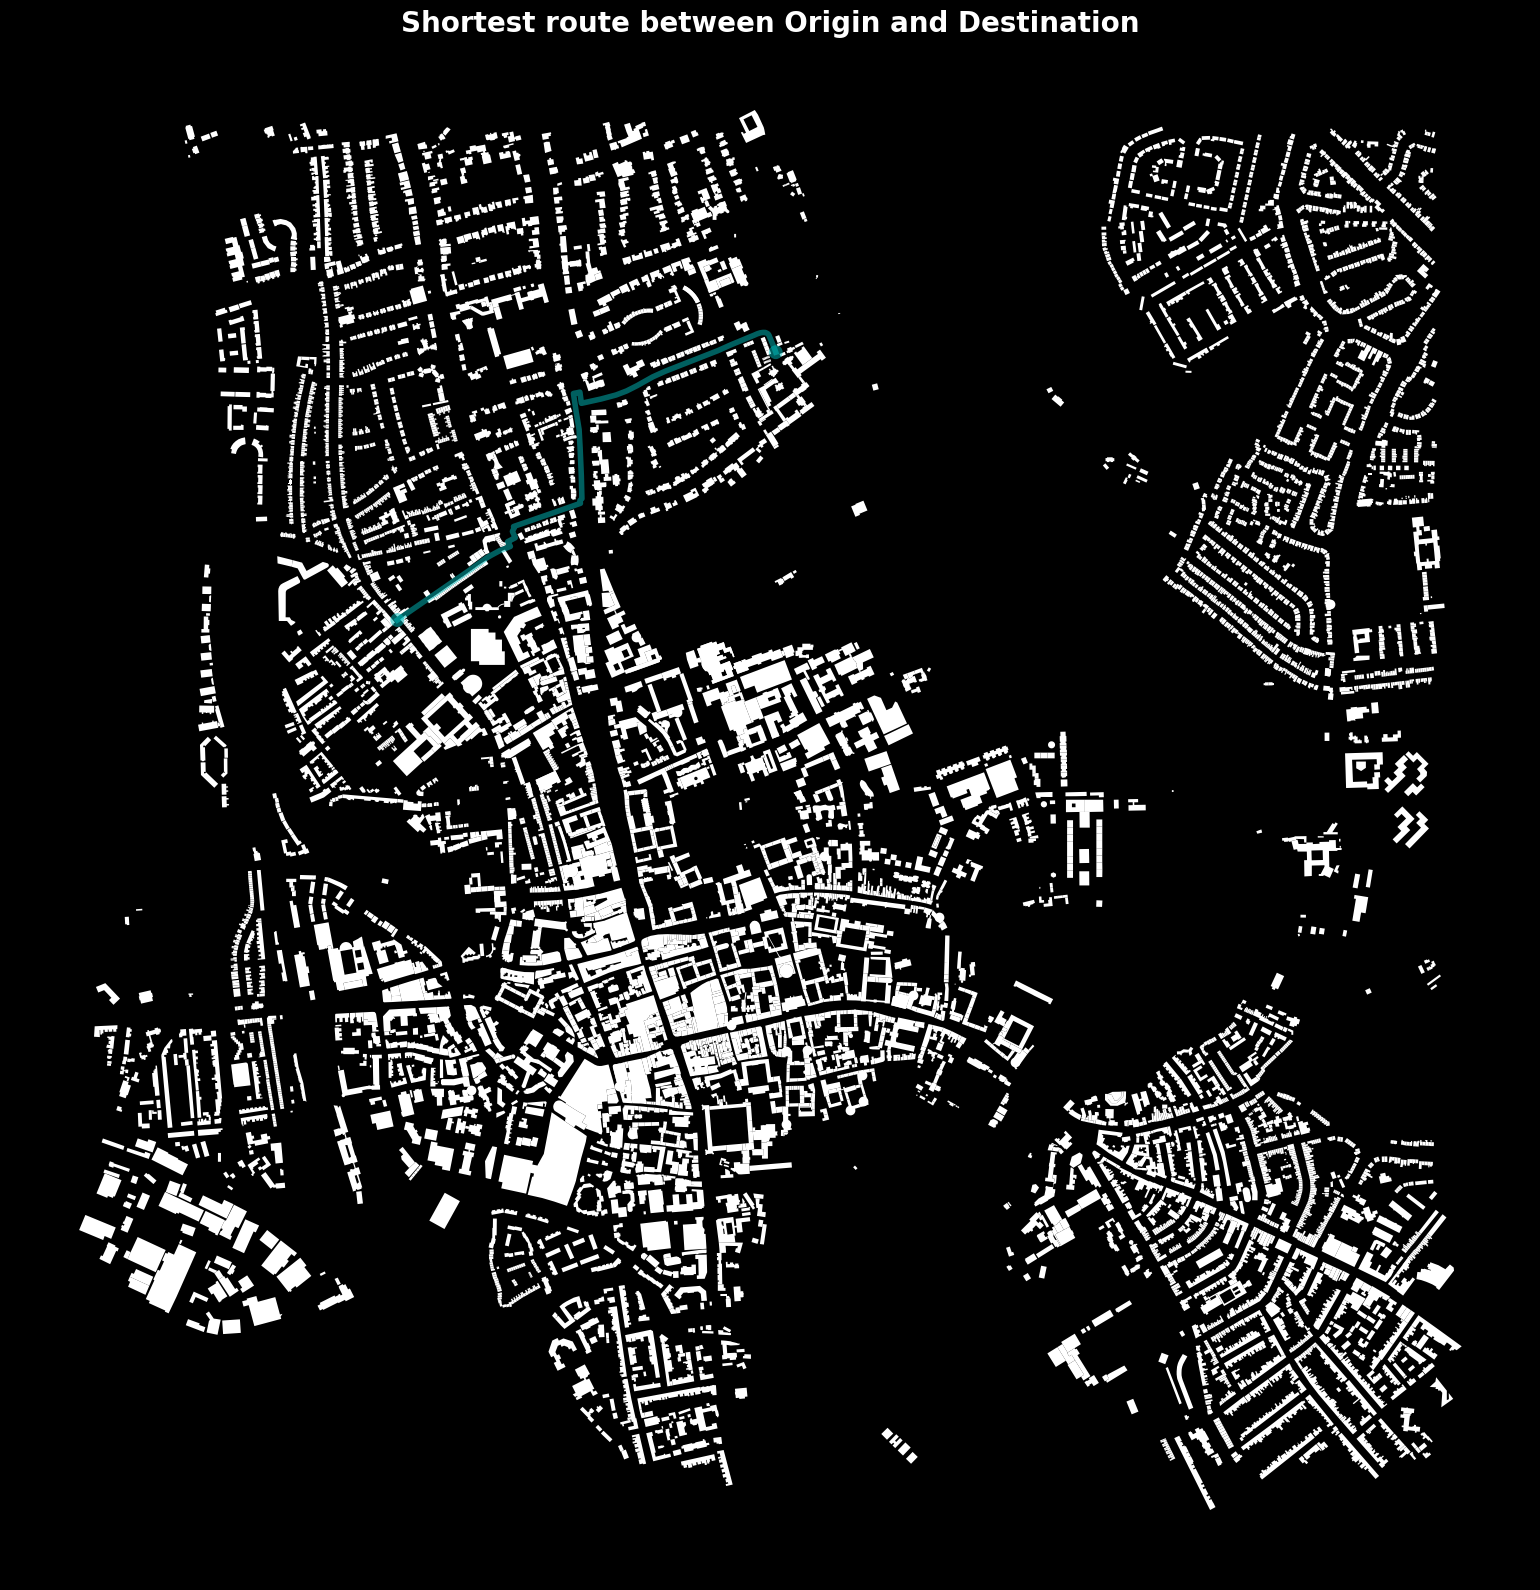

(<Figure size 2000x2000 with 1 Axes>,
 <Axes: title={'center': 'Shortest route between Origin and Destination'}>)

In [ ]:
# 1. Define the origin point
place_name = 'Deneke'
Origin_point = buildings[buildings['name']=='Deneke'].geometry.centroid.iloc[0]

# 2. Find the nearest node in the graph to the origin
origin_node = ox.nearest_nodes(G_walk, Origin_point.x, Origin_point.y)

# 3. Find the nearest retail location to the origin node
# Get all possible destination nodes (from the retail dataframe)
destination_nodes = retail['nodes'].unique()

# Calculate shortest path length from origin to all other nodes
lengths = nx.single_source_dijkstra_path_length(G_walk, origin_node, weight='length')

# Find the closest destination node among the retail locations
min_dist = float('inf')
destination_node = None

for node in destination_nodes:
    if node in lengths and lengths[node] < min_dist:
        min_dist = lengths[node]
        destination_node = node

# 4. Get the shortest path between the origin and the selected destination
route = nx.shortest_path(G_walk, origin_node, destination_node, weight='length')

# 5. Plot the route
fig, ax = plt.subplots(1, 1, figsize=(20, 20), facecolor='k', subplot_kw=dict(aspect='equal'))
ax.set_facecolor('k')
ax.set_axis_off()
ax.set_title('Shortest route between Origin and Destination', fontsize=20, color='w', fontweight='bold')
buildings.plot(color='w', ax=ax)

ox.plot_graph_route(G_walk, route, node_size=2, ax=ax, route_color='c')